In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np
import math
import matplotlib.ticker as ticker

In [2]:
# First method for finding the saturation value. Compares i with i+1 at a certain level in %
def find_saturation_value(column_data):
    for i in range(len(column_data) - 1):
        if abs(column_data.iloc[i] - column_data.iloc[i + 1]) <= 0.01 * abs(column_data.iloc[i]):
            saturation = column_data.iloc[i]
            break
        else:
            saturation = None
    return saturation


In [5]:
folder_path='../data'
sensorsID=['0.0','0.1','0.2','0.3','1.0','1.1','1.2','1.3','2.0','2.1','2.2','2.3','3.0','3.1','3.2','3.3', '4.0','4.1','4.2','4.3']
wavelength= ['1064','532'] #1064
outputpath =  '../plots' #../plots_noADCthr
outputpath_lowlevel ='../plots/LowLevel'
dataset_name = os.path.dirname(os.path.abspath(".")).split(os.path.sep)
print(dataset_name)
datetest = dataset_name.split("_")[0]
boardname = dataset_name.split("_")[1]
print(datetest, boardname)

if not os.path.exists(outputpath_lowlevel):
    os.makedirs(outputpath_lowlevel)
    print(f"Directory '{outputpath_lowlevel}' created.")

['', 'Users', 'mseglar', 'GitHub', 'sensors-analysis']


AttributeError: 'list' object has no attribute 'split'

In [23]:
for wl in wavelength:
    slopes = []
    intercepts= []
    rCoes = []
    stderr = []
    intercepts_stderr = []
    saturationADC = []

    if wl== '532':
    # Rename DataFrame columns
        strg_L = 'Laser Current (mA)'
        temp = '20'
    elif wl == '1064':
        strg_L = 'Laser Power (mW)'
        temp = '25'

    for l in sensorsID:
        sensorID=l
        #print(sensorID)
        filename = f'{folder_path}/{datetest}_{boardname}_{sensorID}_{wavelength}_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['Date-Hour', 'L', 'TotalSum', 'TotalSquareSum', 'meanRefPD', 'stdRefPD', 'Tem', 'RH', 'TotalCounts']
        #T.columns = ['Date-Hour', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Tem', 'RH', 'TotalCounts']

        meanADC=T['TotalSum']/T['TotalCounts']
        stdADC=np.sqrt((T['TotalSquareSum']-T['TotalCounts']*meanADC**2)/(T['TotalCounts']-1))
        
        meanPM=meanADC*0.61e-3 #0.61mV/ADCcount   #this conversion should be done in W not in V might check this one
        stdPM=stdADC*0.61e-3

        #meanPM=4.6e-6*meanADC/0.61e-3 #0.61mV/ADCcount   #this conversion might be incorrect
        #stdPM=stdADC*4.6e-6/0.61e-3

        T['meanADC']=meanADC
        T['stdADC']=stdADC

        T['meanPM']=meanPM
        T['stdPM']=stdPM
        #Tpedestal=T.head(1).copy()
        Tpedestal=T[(T['L']== 0)]
        # Tpedestalid=T[(T['L']== 0)].index
        # Remove the rows from T that corresponds to the pedestal
        T = T.drop(T[(T['L']== 0)].index)
        
        # Find the ADC count saturation value
        # First method: 
        ADCthreshold = find_saturation_value(T['meanADC'])
        print(ADCthreshold)
        if ADCthreshold == None : 
            print('No saturation is found')
            saturationADC.append(-1)
        else: 
            saturationADC.append(ADCthreshold)
            if ADCthreshold > 1:
                Tsaturated=T[(T['meanADC']> ADCthreshold)]
                T = T.drop(T[(T['meanADC']> ADCthreshold)].index)
        
        #Second method:
        #T['diff_meanADC'] = T['meanADC'].diff().abs()
        # print(T[['L', 'meanADC', 'diff_mean']])
        
        #meandiff = T['diff_meanADC'].mean()
        #diff_std = T['diff_meanADC'].std()
        # print(meandiff)
        #T_filtered = T[T['diff_meanADC'] > 0.1*meandiff]
        #T_filtered = T_filtered[T_filtered['L'] > 0]

        res = linregress(T['meanRefPD'], T['meanADC'])
        slope = res.slope 
        intercept = res.intercept
        r=res.rvalue
        se = res.stderr
        intercept_stderr = res.intercept_stderr

        slopes.append(slope)
        intercepts.append(intercept)
        rCoes.append(r)
        stderr.append(se)
        intercepts_stderr.append(intercept_stderr)

        print(f'Calibration coefficient found for sensorID {sensorID} for laser {wavelength} nm = {res.slope} +/- {res.stderr} in ADC/V')

        #fig = plt.figure(1)
        #plt.errorbar(T['L'], T['TotalSum'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
        #plt.ylabel('Total sum ADC counts')
        #plt.xlabel(strg_L)
        #plt.grid()
        #plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
        #plt.tight_layout()
        #plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wavelength}_ADC_L_{datasets}.png')  # Display the current figure
        #plt.show()
        #plt.close(fig)

        fig = plt.figure(2)
        plt.errorbar(T['L'], T['meanADC'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('mean ADC counts')
        plt.xlabel(strg_L)
        plt.grid()
        plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
        plt.tight_layout()
        plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wavelength}_meanADC_L_{datasets}.png',dpi=199)  # Display the current figure
        #plt.show()
        plt.close(fig)


        '''
        fig = plt.figure(3)
        plt.errorbar(T['L'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W) or (V) ?')
        plt.xlabel(strg_L)
        plt.grid()
        plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/{datetest}_{boardname}_{sensorID}_{wavelength}_meanPM_L_{datasets}.png',dpi=199)  # Display the current figure
        #plt.show()
        plt.close(fig)
        '''

        fig = plt.figure(4)
        plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel(strg_L)
        plt.grid()
        plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
        plt.tight_layout()
        plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wavelength}_meanRefPD_L_{datasets}.png',dpi=199)  # Display the current figure
        #plt.show()
        plt.close(fig)

        #the label here are incorrect since meanPM=meanADC*0.61e-3 #0.61mV/ADCcoun. Monica proposed from the baffle paper: 
        #Voltage/ADCcount =3.3V/2**10=0.00322 V/ADCcount
        #4.6 uW/ADCcount*1ADCcount/0.00322V = 1428 uW/V
        '''
        fig = plt.figure(5)
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.plot(T['meanRefPD'], interceptPM + slopePM*T['meanRefPD'], 'r', label='fitted line')
        plt.ylabel('Mean Optical Power (W) or (V) ?')
        plt.xlabel('Mean ref PD (V)')
        plt.grid()
        plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
        plt.tight_layout()
        plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wavelength}_meanPM_meanRefPD_{datasets}.png',dpi=199)  # Display the current figure
        #plt.show()
        plt.close(fig)
        '''

        fig = plt.figure(6)
        plt.errorbar(T['meanRefPD'], T['meanADC'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
        plt.plot(T['meanRefPD'], intercept + slope*T['meanRefPD'], 'r', label='fitted line')
        plt.ylabel('Mean ADC counts')
        plt.xlabel('Mean ref PD (V)')
        plt.grid()
        plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
        plt.tight_layout()
        plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wavelength}_meanADC_meanRefPD_{datasets}.png',dpi=199)  # Display the current figure
        #plt.show()
        plt.close(fig)




4095.0
Calibration coefficient found for sensorID 0.0 for laser 1064 nm = 5413.21534802661 +/- 82.38080704671508 in ADC/V
4093.5583068783067
Calibration coefficient found for sensorID 0.1 for laser 1064 nm = 5973.264389425724 +/- 13.917571259629778 in ADC/V
4024.6250533504053
Calibration coefficient found for sensorID 0.2 for laser 1064 nm = 5929.85143552191 +/- 10.45358626255196 in ADC/V
4050.525042444822
Calibration coefficient found for sensorID 0.3 for laser 1064 nm = 5977.100638991994 +/- 9.652611178988126 in ADC/V
2706.818970993013
Calibration coefficient found for sensorID 1.0 for laser 1064 nm = 5926.731197752837 +/- 11.385603337331254 in ADC/V
4085.2712079543053
Calibration coefficient found for sensorID 1.1 for laser 1064 nm = 5992.759619667592 +/- 9.906658917388954 in ADC/V
4076.6895598554115
Calibration coefficient found for sensorID 1.2 for laser 1064 nm = 5906.427425857243 +/- 10.931791384197442 in ADC/V
4095.0
Calibration coefficient found for sensorID 1.3 for laser 1064

In [15]:
#from tabulate import tabulate

#tabdata=[sensorsID,slopes,intercepts,rCoes,stderr,intercepts_stderr]
#col_names = ["sensorID","slope","intercept","rCoe","stderr","intercept_stderr"]
#print(tabulate(tabdata, headers=col_names))


tabdata = pd.DataFrame()
tabdata["sensorID"]=sensorsID
tabdata["slope"]=slopes
tabdata["intercept"]=intercepts
tabdata["rCoe"]=rCoes
tabdata["stderr"]=stderr
tabdata["intercept_stderr"]=intercepts_stderr
tabdata["saturationADC"] = saturationADC

tabdata


,sensorID,slope,intercept,rCoe,stderr,intercept_stderr,saturationADC
0,0.0,5413.215348,120.253144,0.993010,82.380807,40.332376,4095.000000
1,0.1,5487.335672,117.541492,0.992758,85.019299,41.119527,4095.000000
2,0.2,5939.223504,-20.107674,0.999892,12.210494,5.070988,4093.697105
3,0.3,5977.100639,-18.695687,0.999935,9.652611,3.893346,4050.525042
4,1.0,5373.671256,138.960191,0.992209,86.388164,42.656522,4095.000000
5,1.1,5488.264773,116.582071,0.992678,85.505254,41.497914,4095.000000
6,1.2,5906.427426,-7.840258,0.999914,10.931791,4.474708,4076.689560
7,1.3,5468.093236,116.433271,0.992002,89.081168,43.304389,4095.000000
8,2.0,5455.088865,108.937482,0.992853,83.956063,40.974960,4095.000000
9,2.1,5914.278278,-4.294012,0.999955,7.831808,3.217908,4094.680451


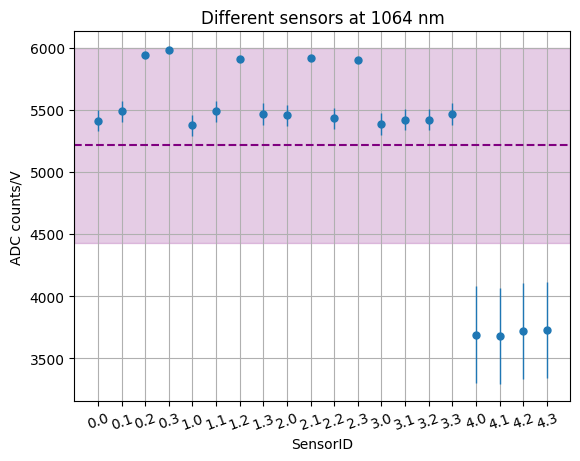

In [16]:
# Customize the plot
fig = plt.figure(100)
plt.errorbar(range(len(slopes)), slopes,stderr, fmt='.', markersize=10, linewidth=1)
plt.title(f'Different sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('ADC counts/V')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(slopes)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.00064, 0.000665])
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wavelength}_calibration_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()


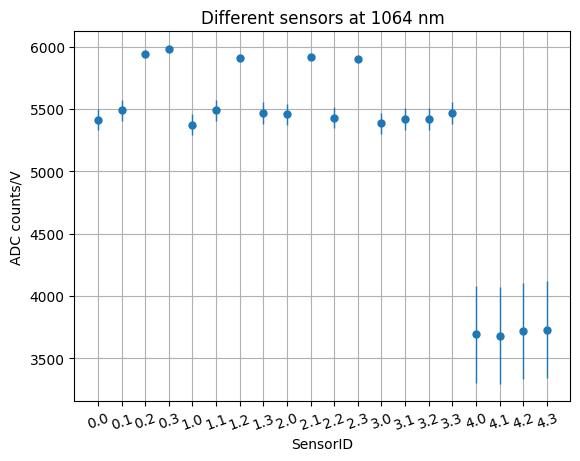

In [17]:
# Customize the plot
fig = plt.figure(100)
plt.errorbar(range(len(slopes)), slopes,stderr, fmt='.', markersize=10, linewidth=1)
plt.title(f'Different sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('ADC counts/V')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(slopes)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes[9:]), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
#plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.00064, 0.000665])
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wavelength}_noshades_calibration_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()

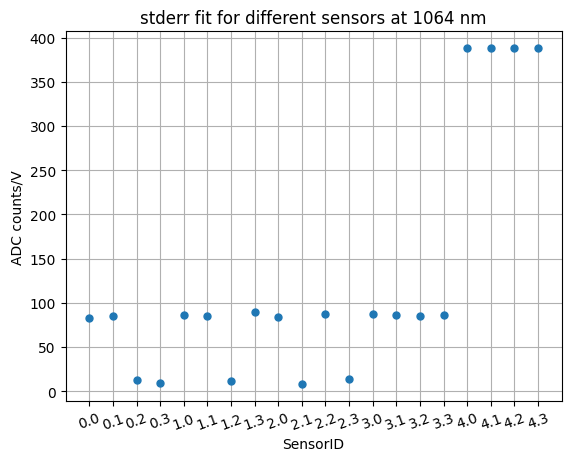

In [18]:
# Customize the plot
fig = plt.figure(200)
plt.errorbar(range(len(stderr)), stderr, fmt='.', markersize=10, linewidth=1)
plt.title(f'stderr fit for different sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('ADC counts/V')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(stderr)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
#plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.00064, 0.000665])
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wavelength}_noshades_stderrs_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()

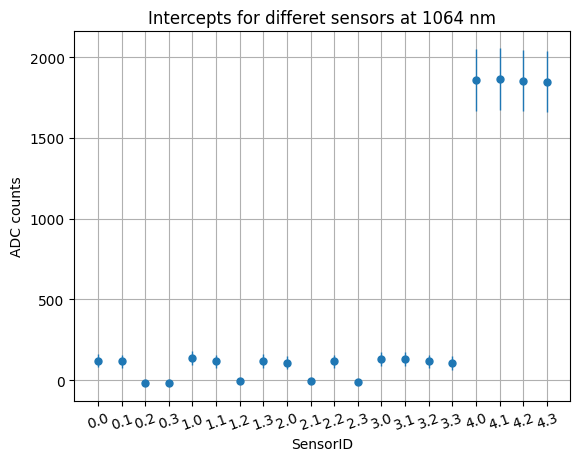

In [19]:
fig = plt.figure(300)
plt.errorbar(range(len(intercepts)), intercepts,intercepts_stderr, fmt='.', markersize=10, linewidth=1)
plt.title(f'Intercepts for differet sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('ADC counts')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(intercepts)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
#plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.00064, 0.000665])
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wavelength}_noshade_intercepts_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()

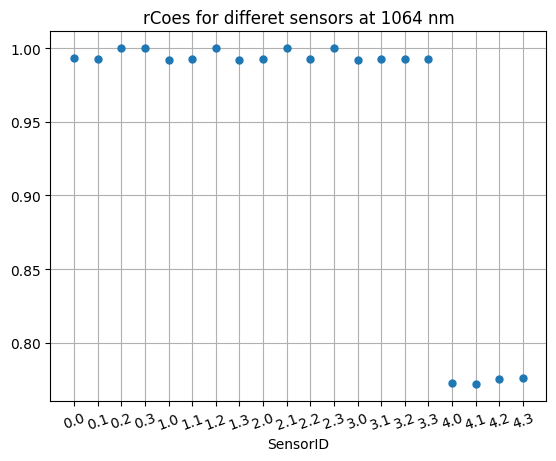

In [20]:
fig = plt.figure(400)
plt.errorbar(range(len(rCoes)), rCoes, fmt='.', markersize=10, linewidth=1)
plt.title(f'rCoes for differet sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(rCoes)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
#plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.9997, 1.00001])
#plt.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wavelength}_noshade_rcoes_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()

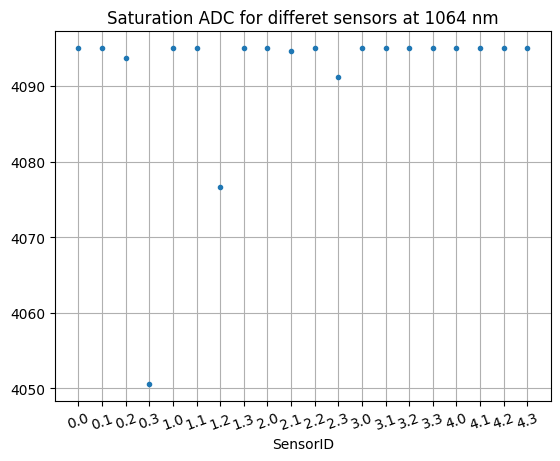

In [21]:
fig = plt.figure(400)
plt.title(f'Saturation ADC for differet sensors at {wavelength} nm')
plt.plot(range(len(saturationADC)), saturationADC,'.')
plt.xlabel('SensorID')
plt.ylabel('')
plt.xticks(np.arange(len(saturationADC)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
#plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.9997, 1.00001])
#plt.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wavelength}_noshade_saturationADC_{datasets}.png',dpi=199)  # Display the current figure
